In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime
import time

from sys import path
path.append(r'E:\data_mining\project\IJCAI-17-口碑\koubei')
import base
import predict

import matplotlib
myfont = matplotlib.font_manager.FontProperties(fname=r'C:/Windows/Fonts/msyh.ttf')
matplotlib.use('qt4agg')  
#指定默认字体  
matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['font.family']='sans-serif'  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus'] = False

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#读取user_pay_count
user_pay_counts = base.ReadUserPayCountCSV();
#读取开店时间数据
shop_open_dates = base.ReadShopOpenDateCSV();
###读取商家信息
shop_infos = base.ReadShopInfoCSV();
##读取城市名称对照表
city_names = base.ReadCityNameCSV();
#读取休假表
calenders = base.ReadCalendarCSV();

In [64]:
def plotShopPayCounts(shop_id, date_range, predicts, names, evaluations, predict_num):
    counts = base.countShopPayTimePeriods(user_pay_counts, shop_id, date_range, [datetime.timedelta(hours=0), datetime.timedelta(hours=23)])
    #counts = base.WipeInvalidUserPayCount(counts)
    counts['holiday'] = calenders.loc[counts.index.strftime('%Y-%m-%d')]['daytype'].values
    info = shop_infos.ix[shop_id]
    weathers = base.readWeatherData(city_names.loc[info['city']])
    counts['weather'] = weathers.loc[counts.index]['desc'].values
    print(counts['count'].values)
    counts = counts.reset_index(drop=True)
    
    train_index = np.array(range(len(counts.index)))
    predict_index = np.array(range(len(counts.index)- predict_num, len(counts.index)))
    mean_index = np.array(range(len(counts.index)- 7 - predict_num, len(counts.index) - predict_num))
    f, (ax) = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(train_index, counts['count'])
    
    temp = counts[counts['holiday'] == 1]
    ax.scatter(temp.index, temp['count'], color='r')
    temp = counts[counts['holiday'] == 2]
    ax.scatter(temp.index, temp['count'], color='g')
    temp = counts[counts['holiday'] == 3]
    ax.scatter(temp.index, temp['count'], color='b')
    temp = counts[counts['holiday'] == 4]
    ax.scatter(temp.index, temp['count'], color='k')
    temp = counts[counts['holiday'] == 5]
    ax.scatter(temp.index, temp['count'], color='y')
    
    for i, name in enumerate(names):
        ax.plot(predict_index, predicts[i].loc[id], label=name)
        print("%s : %f"%(name, evaluations[i][id]))
    
#     ax.text(left, bottom, 'left top',
#         horizontalalignment='left',
#         verticalalignment='top',
#         transform=ax.transAxes)
    
    plt.title(info.cate_1_name + ' ' + info.cate_2_name + ('' if info.cate_3_name is None else info.cate_3_name), fontproperties=myfont)
    mean_value = np.mean(counts['count'][mean_index])
    print('pre_week_mean_value=' + str(mean_value))
    ax.axhline(y=mean_value, linewidth=1, color='r')
    plt.legend()
    plt.show()

In [4]:
mean_3_3_3_prediction = pd.read_csv('../data/train/mean/mean_3_3_3_prediction.txt', sep='\t', index_col=0, encoding='UTF-8')

In [5]:
arima_prediction = pd.read_csv('../data/train/arima/arima_prediction.txt', sep='\t', index_col=0, encoding='UTF-8')
arima_prediction = predict.FixFinalPredict(arima_prediction)

In [6]:
combine_prediction = (mean_3_3_3_prediction + arima_prediction) / 2
combine_prediction = predict.FixFinalPredict(combine_prediction)

In [7]:
diff_prediction = mean_3_3_3_prediction - combine_prediction

In [44]:
start = pd.to_datetime('2016-10-18')
end = pd.to_datetime('2016-10-31')
mean_3_3_3_evaluations = {}
combine_evaluations = {}
arima_evaluations = {}
for id in range(1, 2001):
    print(id)
    y_test = base.getTestCount(user_pay_counts, id, start, end)
    mean_3_3_3_evaluations[id] = base.evaluation(y_test, mean_3_3_3_prediction.loc[id].values)
    combine_evaluations[id] = base.evaluation(y_test, combine_prediction.loc[id].values)
    arima_evaluations[id] = base.evaluation(y_test, arima_prediction.loc[id].values)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [45]:
mean_3_3_3_evaluation_df = pd.DataFrame.from_dict(mean_3_3_3_evaluations, orient='index')
combine_evaluation_df = pd.DataFrame.from_dict(combine_evaluations, orient='index')
arima_evaluation_df = pd.DataFrame.from_dict(arima_evaluations, orient='index')

In [46]:
all_evaluations_df = pd.concat([mean_3_3_3_evaluation_df, combine_evaluation_df, arima_evaluation_df], axis=1)

In [47]:
all_evaluations_df.columns = ['mean', 'combine', 'arima']

In [48]:
all_type_df = all_evaluations_df.idxmin(axis=1)

In [49]:
def changeType(t):
    if t == 'mean':
        return 0
    elif t == 'combine':
        return 1
    elif t == 'arima':
        return 2

In [50]:
y_train_df = all_type_df.apply(changeType)

In [51]:
y_train_df.value_counts()

0    1357
1     422
2     221
dtype: int64

In [52]:
diff_evaluations_df = pd.DataFrame()
diff_evaluations_df['diff_mean'] = all_evaluations_df['mean'] - all_evaluations_df['combine']
diff_evaluations_df['diff_arima'] = all_evaluations_df['arima'] - all_evaluations_df['combine'] 

In [53]:
diff_evaluations_df = diff_evaluations_df.sort_values(['diff_mean', 'diff_arima'])

In [85]:
diff_evaluations_df[diff_evaluations_df['diff_mean'] > 0]

,diff_mean,diff_arima
1643,0.000005,0.004762
477,0.000079,0.005207
1181,0.000099,0.010797
828,0.000119,0.002617
698,0.000158,0.004733
17,0.000219,0.012284
451,0.000265,0.019782
784,0.000266,0.003227
1404,0.000280,0.005511
72,0.000316,0.000752


In [55]:
evaluations = [mean_3_3_3_evaluations, combine_evaluations, arima_evaluations]

In [56]:
predicts = [mean_3_3_3_prediction, combine_prediction, arima_prediction]
names = ['mean', 'combine', 'arima']

In [74]:
i = 1999

2016-09-13 00:00:00
[122 109  27  86  99  94 133 115 116 134 130 142 137 142 140  87  76 431
  36  17   7   0   0   0   0  85  41  40  70  31   1  11  26   1   0   0
   0  22  55  23   2   0   0  12  36  26  26  29  58]
mean : 0.630301
combine : 0.479506
arima : 0.823299
pre_week_mean_value=20.0


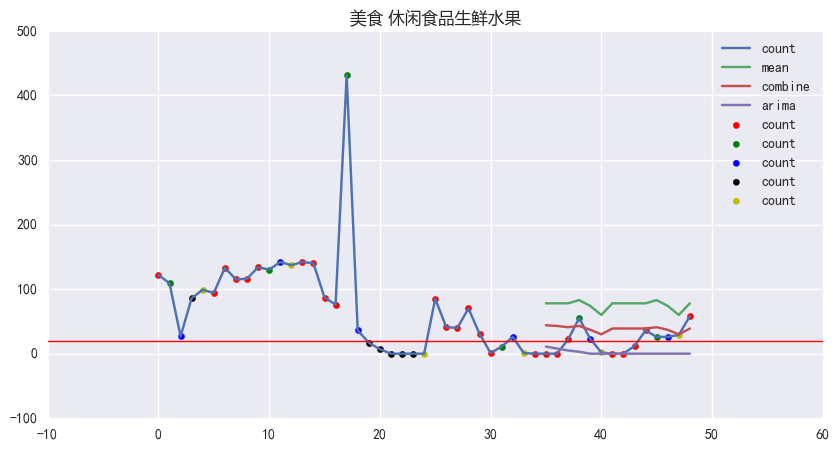

In [90]:
id = diff_evaluations_df.index[i]
i = i - 1
#open_time = shop_open_dates.loc[id]['date'];
open_time = pd.to_datetime('2016-9-13')
start_time = open_time;
end_time = pd.to_datetime('2016-10-31')
print(open_time)
plotShopPayCounts(id, [start_time, end_time], predicts, names, evaluations, 14)

In [174]:
y_train_df = y_train_df.to_frame()

In [175]:
y_train_df = y_train_df.rename(columns={0:'type'})

In [176]:
all_evaluations_df[all_evaluations_df.idxmin(axis=1) == 'mean_arima']

,mean,mean_arima
5,0.275382,0.254574
6,0.098516,0.081196
10,0.092125,0.087205
13,0.033075,0.030802
14,0.124112,0.092160
16,0.100707,0.099157
22,0.115856,0.096071
27,0.057970,0.056686
30,0.080781,0.070038
42,0.090766,0.069574


In [177]:
temp = all_evaluations_df.min(axis=1)

In [178]:
temp.mean()

0.07835791652199593

In [42]:
mean_arima_evaluation_df[0].mean()

0.0932742045805763

In [36]:
y_train_df

0.0

In [13]:
np.mean(mean_evaluation_df[0])

0.08412703729077396

In [14]:
np.mean(arima_evaluation_df[0]) 

0.11964804607385393

In [15]:
np.mean(mean_arima_evaluation_df[0]) 

0.0932742045805763

In [69]:
np.mean(filter_evaluation_df[0]) 

0.10530664146369142

In [22]:
mean_arima_evaluation_df.sort_values(0)

,0
516,0.020333
968,0.023776
1885,0.025105
1365,0.025244
775,0.027605
1976,0.027930
1932,0.028069
1489,0.028720
973,0.029360
1025,0.029457


In [88]:
diff_evaluation = mean_evaluation_df - mean_arima_evaluation_df

In [101]:
mean_evaluation_data_df = pd.concat([diff_mean, diff_evaluation], axis=1)

In [103]:
mean_evaluation_data_df.columns = ['mean', 'evaluation']

In [104]:
mean_evaluation_data_df.to_csv('../data/compare/mean_evaluation.csv')

In [136]:
filter_prediction_df = pd.DataFrame(filter_prediction)

In [137]:
filter_prediction_df = filter_prediction_df.T

In [ ]:
min_evaluations = 

In [32]:
train_data = pd.read_csv('../data/train/real_train_data.txt', sep='\t', index_col=0, encoding='UTF-8')

In [75]:
train_data.columns = np.array(range(35))

In [81]:
X_train_data = train_data[np.array(range(21))]

In [94]:
X_train_data.shape

(2000, 21)

In [151]:
X_train_df = pd.DataFrame()
X_train_df['max'] = X_train_data.max(axis=1)
X_train_df['min'] = X_train_data.min(axis=1)
X_train_df['std'] = X_train_data.std(axis=1)
X_train_df['var'] = X_train_data.var(axis=1)
X_train_df['mean'] = X_train_data.mean(axis=1)
X_train_df['median'] = X_train_data.median(axis=1)

In [152]:
X_train_df['arima_max'] = arima_prediction.max(axis=1) - X_train_data.max(axis=1)
X_train_df['arima_min'] = arima_prediction.min(axis=1) - X_train_data.min(axis=1)
X_train_df['arima_std'] = arima_prediction.std(axis=1) - X_train_data.std(axis=1)
X_train_df['arima_var'] = arima_prediction.var(axis=1)- X_train_data.var(axis=1)
X_train_df['arima_mean'] = arima_prediction.mean(axis=1) - X_train_data.mean(axis=1)
X_train_df['arima_median'] = arima_prediction.median(axis=1) - X_train_data.median(axis=1)

X_train_df['mean_max'] = mean_3_3_3_prediction.max(axis=1) - X_train_data.max(axis=1)
X_train_df['mean_min'] = mean_3_3_3_prediction.min(axis=1) - X_train_data.min(axis=1)
X_train_df['mean_std'] = mean_3_3_3_prediction.std(axis=1) - X_train_data.std(axis=1)
X_train_df['mean_var'] = mean_3_3_3_prediction.var(axis=1) - X_train_data.var(axis=1)
X_train_df['mean_mean'] = mean_3_3_3_prediction.mean(axis=1) - X_train_data.mean(axis=1)
X_train_df['mean_median'] = mean_3_3_3_prediction.median(axis=1) - X_train_data.median(axis=1)

X_train_df['combine_max'] = mean_3_3_3_arima_prediction.max(axis=1) - X_train_data.max(axis=1)
X_train_df['combine_min'] = mean_3_3_3_arima_prediction.min(axis=1) - X_train_data.min(axis=1)
X_train_df['combine_std'] = mean_3_3_3_arima_prediction.std(axis=1) - X_train_data.std(axis=1)
X_train_df['combine_var'] = mean_3_3_3_arima_prediction.var(axis=1) - X_train_data.var(axis=1)
X_train_df['combine_mean'] = mean_3_3_3_arima_prediction.mean(axis=1) - X_train_data.mean(axis=1)
X_train_df['combine_median'] = mean_3_3_3_arima_prediction.median(axis=1) - X_train_data.median(axis=1)

X_train_df['diff_mean_arima_max'] = mean_3_3_3_prediction.max(axis=1) - arima_prediction.max(axis=1)
X_train_df['diff_mean_arima_min'] = mean_3_3_3_prediction.min(axis=1) - arima_prediction.min(axis=1)
X_train_df['diff_mean_arima_std'] = mean_3_3_3_prediction.std(axis=1) - arima_prediction.std(axis=1)
X_train_df['diff_mean_arima_var'] = mean_3_3_3_prediction.var(axis=1) - arima_prediction.var(axis=1)
X_train_df['diff_mean_arima_mean'] = mean_3_3_3_prediction.mean(axis=1) - arima_prediction.mean(axis=1)
X_train_df['diff_mean_arima_median'] = mean_3_3_3_prediction.median(axis=1) - arima_prediction.median(axis=1)

X_train_df['diff_mean_combine_max'] = mean_3_3_3_prediction.max(axis=1) - mean_3_3_3_arima_prediction.max(axis=1)
X_train_df['diff_mean_combine_min'] = mean_3_3_3_prediction.min(axis=1) - mean_3_3_3_arima_prediction.min(axis=1)
X_train_df['diff_mean_combine_std'] = mean_3_3_3_prediction.std(axis=1) - mean_3_3_3_arima_prediction.std(axis=1)
X_train_df['diff_mean_combine_var'] = mean_3_3_3_prediction.var(axis=1) - mean_3_3_3_arima_prediction.var(axis=1)
X_train_df['diff_mean_combine_mean'] = mean_3_3_3_prediction.mean(axis=1) - mean_3_3_3_arima_prediction.mean(axis=1)
X_train_df['diff_mean_combine_median'] = mean_3_3_3_prediction.median(axis=1) - mean_3_3_3_arima_prediction.median(axis=1)

X_train_df['diff_arima_combine_max'] = arima_prediction.max(axis=1) - mean_3_3_3_arima_prediction.max(axis=1)
X_train_df['diff_arima_combine_min'] = arima_prediction.min(axis=1) - mean_3_3_3_arima_prediction.min(axis=1)
X_train_df['diff_arima_combine_std'] = arima_prediction.std(axis=1) - mean_3_3_3_arima_prediction.std(axis=1)
X_train_df['diff_arima_combine_var'] = arima_prediction.var(axis=1) - mean_3_3_3_arima_prediction.var(axis=1)
X_train_df['diff_arima_combine_mean'] = arima_prediction.mean(axis=1) - mean_3_3_3_arima_prediction.mean(axis=1)
X_train_df['diff_arima_combine_median'] = arima_prediction.median(axis=1) - mean_3_3_3_arima_prediction.median(axis=1)


In [153]:
from sklearn import preprocessing

In [154]:
X_train_scaled = preprocessing.scale(X_train_df.values)

In [155]:
X_train_df = pd.DataFrame(X_train_scaled)

In [156]:
# X_train_df['last_max'] = X_train_data.max(axis=1) == X_train_data[20]
# X_train_df['last_min'] = X_train_data.min(axis=1) == X_train_data[20]
# X_train_df[['last_max', 'last_min']] = X_train_df[['last_max', 'last_min']].applymap(lambda x : 1 if x == True else 0)

In [157]:
X_train_df.to_csv('../data/train/model_classes_X_train.csv')

In [158]:
y_train_df.to_csv('../data/train/model_classes_y_train.csv')

In [129]:
X_train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,last_max,last_min
0,0.373587,1.262140,-0.352436,-0.160863,0.752176,0.791814,-0.464889,0.690885,-0.137847,-0.253520,0.718417,-0.108806,-0.407094,0.709753,-0.119103,0,0
1,-0.349169,-0.823113,0.374559,-0.022239,-0.530679,-0.446799,0.082781,-0.393350,-0.084851,-0.473070,-1.018668,-0.113267,-0.057579,-0.714391,-0.094342,0,0
2,-0.449551,-0.266371,-0.423586,-0.168302,-0.443085,-0.454352,-0.209401,-0.428626,-0.120334,-0.431929,-0.417251,-0.113111,-0.269065,-0.427068,-0.111899,0,1
3,0.102553,-0.104409,0.280314,-0.046644,-0.072816,-0.174909,0.610426,-0.096612,0.021005,0.688238,-0.157816,0.011555,0.722721,-0.127795,0.038691,0,0
4,0.504084,-0.823113,2.038411,0.724271,0.046536,0.368873,0.356933,0.311144,-0.036562,-0.473070,0.948114,-0.113267,0.141513,0.634416,-0.070604,0,0
5,-0.359207,-0.266371,-0.415753,-0.167537,-0.412025,-0.439247,-0.566918,-0.402687,-0.141318,-0.440573,-0.382386,-0.113170,-0.538398,-0.396414,-0.122838,0,0
6,-0.002848,0.118288,-0.148764,-0.133528,-0.038616,-0.008753,-0.109874,-0.058222,-0.110099,-0.473070,-0.049633,-0.113267,-0.207008,-0.053497,-0.107565,0,0
7,-0.524838,-0.327106,-0.474390,-0.172946,-0.486358,-0.507220,-0.451991,-0.512667,-0.137265,-0.320503,-0.472624,-0.111113,-0.410864,-0.495132,-0.119253,0,0
8,0.579371,1.120424,0.048042,-0.098609,0.809757,0.867339,-0.007826,0.745875,-0.097618,-0.473070,0.804553,-0.113267,-0.136678,0.781974,-0.101832,0,0
9,-0.489705,-0.306861,-0.459646,-0.171655,-0.442387,-0.454352,-0.520391,-0.414100,-0.139985,-0.204096,-0.289072,-0.106571,-0.466123,-0.353289,-0.121158,0,0


In [113]:
X_train_df.to_csv()

,max,min,std,var,mean,median,last_max,last_min,arima_std,arima_mean,arima_var,mean_std,mean_mean,mean_var,mean_arima_std,mean_arima_mean,mean_arima_var
1,283,206,21.846979,477.290476,242.238095,241.0,0,0,8.654542,236.142857,74.901099,4.278749,242.000000,18.307692,5.846479,238.785714,34.181319
2,139,0,52.386658,2744.361905,67.190476,77.0,0,1,29.521458,86.857143,871.516484,0.000000,0.000000,0.000000,14.853127,43.000000,220.615385
3,119,55,18.858117,355.628571,79.142857,76.0,0,0,18.388960,82.000000,338.153846,0.801784,83.785714,0.642857,9.403355,82.500000,88.423077
4,229,71,48.427609,2345.233333,129.666667,113.0,0,0,49.625410,127.714286,2462.681319,22.632394,119.928571,512.225275,34.960653,123.642857,1222.247253
5,309,0,122.281837,14952.847619,145.952381,185.0,0,0,39.967019,183.857143,1597.362637,0.000000,274.000000,0.000000,19.983510,228.428571,399.340659
6,137,55,19.187173,368.147619,83.380952,78.0,0,0,4.767103,85.571429,22.725275,0.633324,88.642857,0.401099,2.462912,86.714286,6.065934
7,208,93,30.402851,924.333333,134.333333,135.0,0,0,22.181073,133.000000,492.000000,0.000000,135.000000,0.000000,11.002497,133.857143,121.054945
8,104,49,16.723949,279.690476,73.238095,69.0,0,0,9.145947,70.428571,83.648352,2.973325,76.071429,8.840659,5.749343,73.142857,33.054945
9,324,192,38.670279,1495.390476,250.095238,251.0,0,0,26.069223,243.714286,679.604396,0.000000,254.000000,0.000000,12.814827,248.714286,164.219780
10,111,51,17.343312,300.790476,79.238095,76.0,0,0,6.539819,84.000000,42.769231,5.241948,101.642857,27.478022,4.325366,92.642857,18.708791
